In [1]:
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
from scipy.stats import poisson
import matplotlib.patches as mpatches
from functools import partial
import pandas as pd
import pickle
import os
import demixing as dm
from demixing import MLP, HiddenLayer

nneuron = 61
min_angle = -90
max_angle = 90
sprefs = np.linspace(min_angle, max_angle, nneuron)
eps = np.finfo(np.float64).eps
sigtc_sq = float(10**2)

In [46]:
nns = {}
nn_df = pd.DataFrame(index=np.arange(0, 400), columns=('valid_nn', 'c'))
for i in range(600):
    file_name = 'output_nn_runs/nn_runs' + str(i) + '.pkl'
    if os.path.isfile(file_name):
        pkl_file = open(file_name, 'rb')
        nn, nnx, valid_mse, stats, c = pickle.load(pkl_file)
        nns[i] = nn
        nn_df.loc[i] = [valid_mse[99], c]

In [47]:
nn_df.sort('valid_nn', ascending=1)

,valid_nn,c
212,11.19249,4
572,11.22694,4
476,11.25484,4
116,11.26347,4
398,11.30895,4
512,11.34867,4
464,11.46342,4
581,11.47842,4
104,11.52729,4
506,11.53309,4


In [3]:
nns = {}
nn_df = pd.DataFrame(index=np.arange(0, 400), columns=('valid_nn', 's'))
for i in range(400):
    file_name = 'output_nn_tests_2/nn_tests_2_' + str(i) + '.pkl'
    if os.path.isfile(file_name):
        pkl_file = open(file_name, 'rb')
        nn, nnx, valid_mse, stats, c = pickle.load(pkl_file)
        nns[i] = (nn, nnx, valid_mse)
        nn_df.loc[i] = [valid_mse[99]]

In [4]:
nn_df.sort('valid_nn', ascending=1)

,valid_nn,s
43,30.25526,30.25526
105,30.75156,30.75156
331,31.34906,31.34906
107,31.42467,31.42467
133,31.43485,31.43485
261,32.17634,32.17634
95,32.28916,32.28916
324,32.30989,32.30989
18,32.42958,32.42958
370,32.49053,32.49053


In [5]:
nn, _, _ = nns[43]

In [9]:
def python_relu(x):
    return x * (x > 0)

In [6]:
def get_hu_responses(r, nn):
    nn_params = nn.get_params()
    b = nn_params['b']
    W = nn_params['W']
    trials = python_relu(np.dot(r, W) + b)
    return trials

In [12]:
def get_mean_acts(s_arr, nn, c):
    l_sarr = len(s_arr)
    acts = np.zeros((l_sarr, l_sarr, 20))
    for i in range(l_sarr):
        for j in range(i+1, l_sarr):
            s1 = s_arr[i]
            s2 = s_arr[j]
            r, _, _ = dm.generate_testset(300, stim_0=s1, stim_1=s2, discrete_c=c, r_max=1)
            acts[i][j] = np.mean(get_hu_responses(r, nn), axis=0)
    return np.array(acts)

In [13]:
c_arr = [[[1, 2, 4], [1, 2, 4]]]
s_arr = np.linspace(-60, 60, 120)
acts = get_mean_acts(s_arr, nn, c_arr[0])

33 trials per contrast level
Not divisible, only generated 297 trials
33 trials per contrast level
Not divisible, only generated 297 trials
33 trials per contrast level
Not divisible, only generated 297 trials
33 trials per contrast level
Not divisible, only generated 297 trials
33 trials per contrast level
Not divisible, only generated 297 trials
33 trials per contrast level
Not divisible, only generated 297 trials
33 trials per contrast level
Not divisible, only generated 297 trials
33 trials per contrast level
Not divisible, only generated 297 trials
33 trials per contrast level
Not divisible, only generated 297 trials
33 trials per contrast level
Not divisible, only generated 297 trials
33 trials per contrast level
Not divisible, only generated 297 trials
33 trials per contrast level
Not divisible, only generated 297 trials
33 trials per contrast level
Not divisible, only generated 297 trials
33 trials per contrast level
Not divisible, only generated 297 trials
33 trials per contra

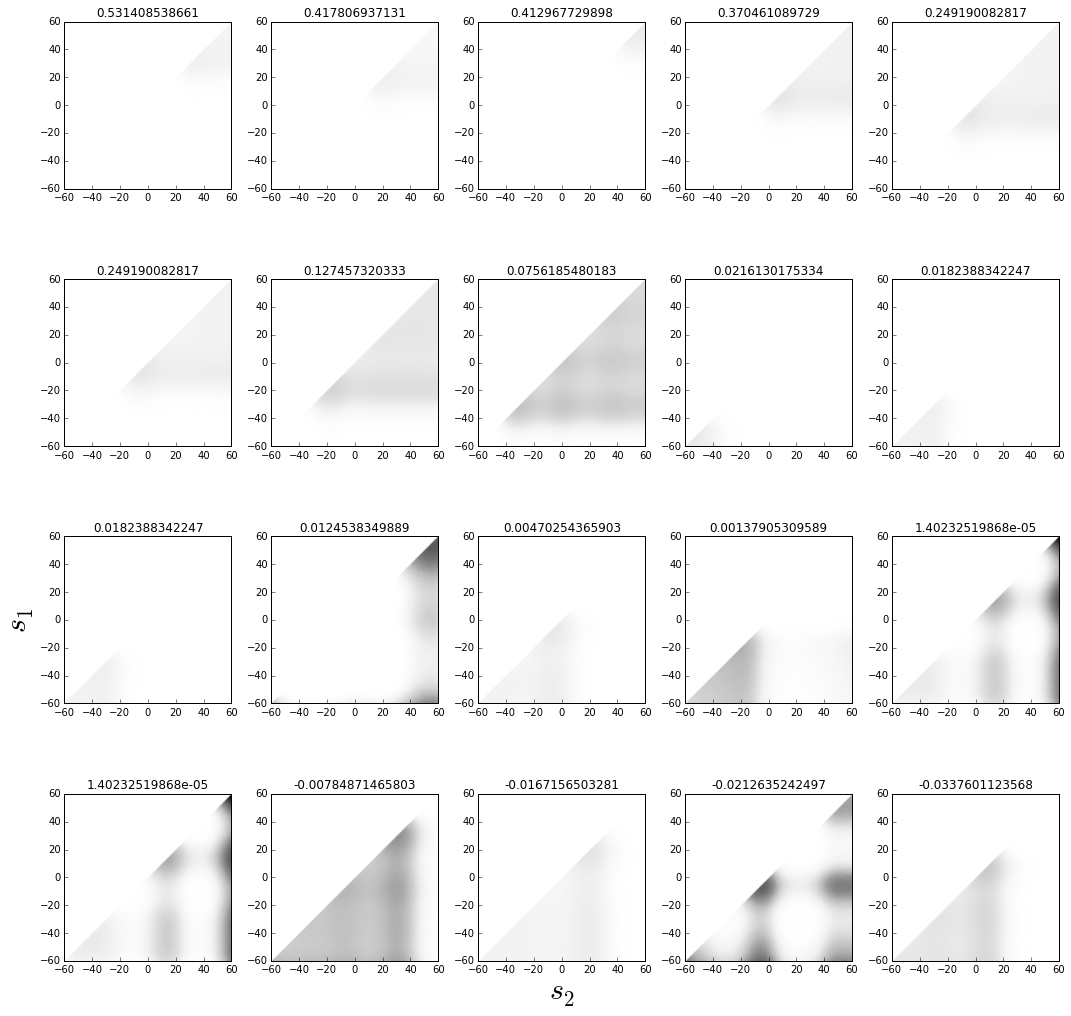

In [43]:
%matplotlib inline
sort_arr = np.argsort(nn.get_params()['W', 2][:, 0], axis=0)[::-1]
f, axarr = plt.subplots(4, 5)
for i in range(4):
    for j in range(5):
        ind = i * 4 + j
        sort_ind = sort_arr[ind]
        axarr[i,j].imshow(acts[:, :, sort_ind],  origin='lower', cmap='Greys', extent=(-60, 60, -60, 60), vmax=np.max(acts))
        axarr[i,j].yaxis.set_ticks_position('left')
        axarr[i,j].xaxis.set_ticks_position('bottom')
        axarr[i,j].set_title(nn.get_params()['W', 2][sort_ind][0])
axarr[2,0].set_ylabel("$s_1$", fontsize = 30)
axarr[3,2].set_xlabel("$s_2$", fontsize = 30)
f.set_size_inches(15,15)
plt.tight_layout()

In [37]:
np.argsort(nn.get_params()['W', 2][:, 0], axis=0)

array([12,  6,  5, 18, 14,  8, 17,  1, 15,  3, 11,  0, 19, 16,  2,  7,  9,
       10,  4, 13])